In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

from utils.utils import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import wget
import os
from utils import PRODUCED_DATASETS
from zipfile import ZipFile


def download_zip(url, force_download=False):
    '''
    Download TAB_SIH.zip and save in cache.
    
    Returns
    -------
        local path to the downloaded file
    '''
    filename = wget.detect_filename(url)
    local_file = os.path.join(PRODUCED_DATASETS, filename)
    if not os.path.exists(local_file) or force_download:
        wget.download(url, localfile)
    return local_file
        
from dbfread import DBF
import re

def make_maps(force_download=False):
    
    CID_URL = 'http://www.datasus.gov.br/cid10/V2008/downloads/CID10CSV.zip'
    local_zipfile = download_zip(CID_URL, force_download)
    with ZipFile(local_zipfile) as zfile:
        l = zfile.namelist()
#         print(l)
        
        with zfile.open('CID-10-SUBCATEGORIAS.CSV') as cid_file:
            cid_map = pd.read_csv(cid_file, sep=';', encoding='iso-8859-1', usecols=['SUBCAT', 'DESCRICAO'],
                                 index_col='SUBCAT', squeeze=True)

    
    TAB_SIH_URL = 'ftp://ftp.datasus.gov.br/dissemin/publicos/SIHSUS/200801_/Auxiliar/TAB_SIH.zip'
    local_zipfile = download_zip(TAB_SIH_URL, force_download)
    with ZipFile(local_zipfile) as zfile:
        l = zfile.namelist()
#         print(l)
        
        # COMPLEX2.CNV
        with zfile.open('COMPLEX2.CNV') as file:
            comp_map = pd.read_table(file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                       skiprows=1, header=None).applymap(func_decode)
            comp_map = {'00': 'Não se aplica',
                        '01': 'Atenção básica',
                        '02': 'Média complexidade',
                        '03': 'Alta complexidade',
                        '99': 'Não se aplica'}
            #fiz manualmente porque não funcionou o encoding e o decode
    
        # FINANC.CNV
        with zfile.open('FINANC.CNV') as file:
            df = pd.read_table(file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                   skiprows=1, header=None).applymap(func_decode)
            temp = pd.DataFrame([{1:'Não discriminado', 2:'00'}, {1:'Não discriminado', 2:'99'},
                                 {1:'04 Fundo de Ações Estratégicas e Compensações FAEC', 2:'04'}])
            df = pd.concat([df, temp], ignore_index=True).drop(0, axis=1).drop([0, 3])
            financ_map = pd.Series(df[1].tolist(), index=df[2].tolist())
        
        # ETNIA
        with zfile.open('etnia.cnv') as et_file:
            df_et = pd.read_table(et_file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                   skiprows=1, header=None).applymap(func_decode)
            ni = pd.DataFrame([{1:'NÃO INFORMADO', 2:'0000'}, {1:'NÃO INFORMADO', 2:'9999'}])
            df_et = pd.concat([df_et, ni], ignore_index=True).drop(0, axis=1).drop(0)
            et_map = pd.Series(df_et[1].tolist(), df_et[2].tolist())
    
        # SEX
        with zfile.open('SEXO.CNV') as sex_file:
            df = pd.read_table(sex_file, sep=b'\s{2,}', engine='python',
                               skiprows=1, header=None).applymap(func_decode)
            sex_map = {df.loc[0, 2][0]: df.loc[0, 1],
                       df.loc[0, 2][2]: df.loc[0, 1],
                       df.loc[1, 2]:    df.loc[1, 1],
                       df.loc[2, 2][0]: df.loc[2, 1],
                       df.loc[2, 2][2]: df.loc[2, 1]}

        # UF
        with zfile.open('br_ufsigla.cnv') as uf:
            df = pd.read_table(uf, sep=b'\s{2,}', engine='python',
                               skiprows=1, header=None).applymap(func_decode).dropna(axis=1)
            pe = pd.DataFrame([{1:'PE', 2:'20'}, {1:'PE', 2:'26'}])
            df = pd.concat([df, pe], ignore_index=True)
            df.drop(12, inplace=True)
            uf_map = pd.Series(df[1].tolist(), df[2].tolist())
            
        # CNES
        list_df = []
        list_cnes = [item for item in l if re.search('\S+CNES\S+', item)]
        for file in list_cnes:
            zfile.extract(file)
            dbf = DBF(file, encoding='utf-8')
            cnes_temp = pd.DataFrame(list(dbf))
            list_df.append(cnes_temp)
            os.unlink(file)
        cnes_br = pd.concat(list_df, sort=False).drop_duplicates()
        cnes_br['UF_ZI'] = cnes_br.UF_ZI.map(uf_map)
        cnes_map = pd.Series(cnes_br.NOMEFANT.tolist(), index=cnes_br.CNES.tolist())
    
        # CBO.dbf
        file = 'CBO.dbf'
        zfile.extract(file)
        dbf = DBF(file, encoding='iso-8859-1')
#         print(list(dbf))
        cbo_map = pd.DataFrame(list(dbf))
        cbo_map = pd.Series(cbo_map.DS_CBO.tolist(), index=cbo_map.CBO.tolist())
        os.unlink(file)
        
    
    
    return sex_map, cnes_map, uf_map, cid_map, et_map, financ_map, cbo_map, comp_map


def func_decode(x):
    if type(x) == bytes:
        try:
            return x.decode()
        except UnicodeDecodeError:
            return x.decode(encoding='iso-8859-1')

sex_map, cnes_map, uf_map, cid_map, et_map, financ_map, cbo_map, comp_map = make_maps()

In [3]:
%%time
hemato = make_all_dataset(force_download='no')

# só apagar linhas abaixo após proximo force 'soft'
hemato['ETNIA'] = hemato.ETNIA.fillna('0000')
hemato.VAL_SH_FED.fillna(0, inplace=True)
hemato.VAL_SP_FED.fillna(0, inplace=True)
hemato.VAL_SH_GES.fillna(0, inplace=True)
hemato.VAL_SP_GES.fillna(0, inplace=True)
hemato.NASC = pd.to_datetime(hemato.NASC)

hemato.drop(['VAL_UCI', 'MARCA_UCI', 'CNPJ_MANT', 'CGC_HOSP', 'DIAG_SECUN',
             'CID_ASSO', 'CID_MORTE', 'VAL_SADT', 'VAL_ACOMP', 'VAL_SANGUE'], axis=1, inplace=True)

cols = 'N_AIH DT_INTER DT_SAIDA US_TOT DIAS_PERM ANO_CMPT DIAG_PRINC MORTE IDADE CNES UF SEXO ETNIA COMPLEX\
        CAR_INT'.split()
hemato = hemato[cols]

Optimizing df...

Original df size: Total memory usage: 1530.61 MB
Optimized df size: Total memory usage: 154.20 MB
CPU times: user 27.7 s, sys: 2.5 s, total: 30.2 s
Wall time: 23 s


In [4]:
hemato.head()

,N_AIH,DT_INTER,DT_SAIDA,US_TOT,DIAS_PERM,ANO_CMPT,DIAG_PRINC,MORTE,IDADE,CNES,UF,SEXO,ETNIA,COMPLEX,CAR_INT
index,,,,,,,,,,,,,,,
24,1216100534044,2016-12-21,2016-12-25,74.330002,4,2017,D693,0,8,5336171,AC,1,0000,02,02
157,1217100010049,2017-01-03,2017-01-06,22.629999,3,2017,C837,0,1,2000385,AC,3,0000,02,01
159,1217100010104,2017-01-04,2017-01-31,846.440002,27,2017,C920,0,2,2000385,AC,1,0000,02,01
214,1217100011028,2016-12-30,2017-01-03,76.919998,4,2017,D692,0,5,2000385,AC,3,0000,02,01
245,1217100034612,2017-01-12,2017-01-20,87.269997,8,2017,D689,0,32,5336171,AC,3,0000,02,02


In [5]:
X = hemato.copy() #drop('US_TOT', axis=1)
y = hemato.US_TOT

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_labeled = {}
for col in X.select_dtypes(exclude='number').columns:
    le = LabelEncoder()
    
    #save it on a dict to make the inverse transform if needed
    X[col] = le.fit_transform(X[col])
    X_labeled[col] = le

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

/home/gui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, uint16, int64, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/gui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, uint16, int64, float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


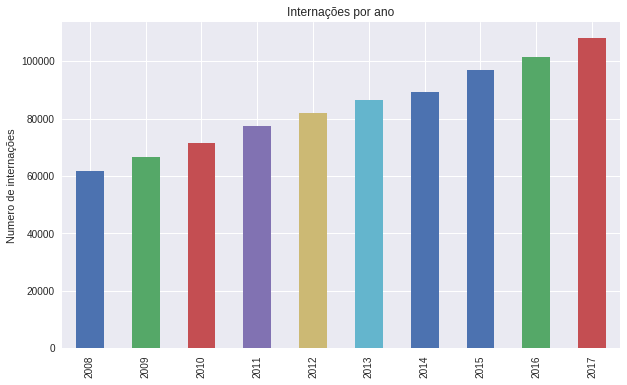

In [6]:
# internações por ano:
# TODO: compare with IBGE data

hemato.ANO_CMPT.value_counts().sort_index().plot(kind='bar', title='Internações por ano', figsize=(10, 6))
plt.ylabel('Numero de internações')
plt.show()

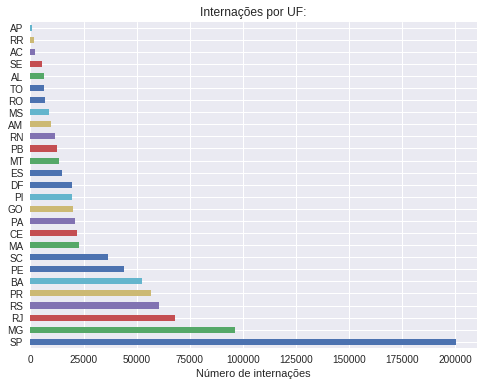

In [7]:
# TODO: compare with IBGE data

hemato.UF.value_counts().plot(kind='barh', figsize=(8, 6))
plt.title('Internações por UF:')
plt.xlabel('Número de internações')
plt.show()

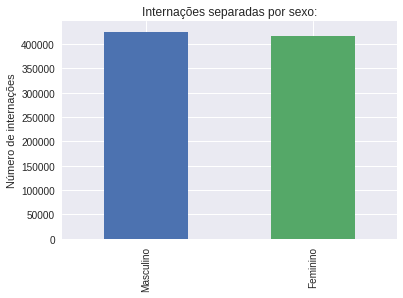

In [8]:
# internações por sexo

hemato.SEXO.map(sex_map).value_counts().plot(kind='bar')
plt.title('Internações separadas por sexo:')
plt.ylabel('Número de internações')
plt.show()

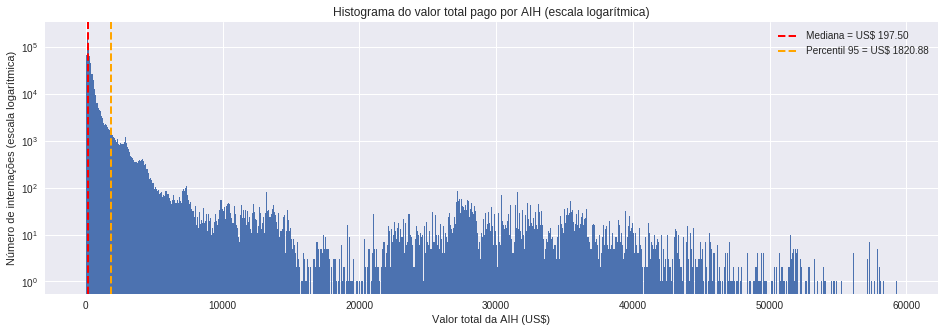

In [9]:
# valor total recebido por AIH
# a escala é logarítmica por causa da amplitude dos valores

hemato.US_TOT.hist(log=True, bins=int(np.sqrt(len(hemato))), figsize=(16, 5))
median = hemato.US_TOT.quantile(.5)

q = .95
p = hemato.US_TOT.quantile(q)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = US$ {:.2f}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2,
            label='Percentil {:.0f} = US$ {:.2f}'.format(q * 100, p))

plt.xlabel('Valor total da AIH (US$)')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do valor total pago por AIH (escala logarítmica)')
plt.show()

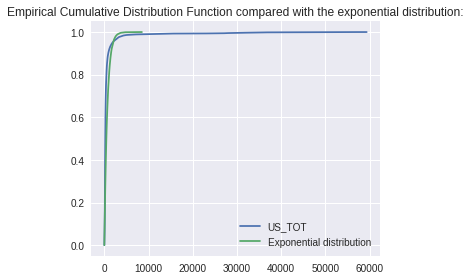

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(hemato.US_TOT)

mean = hemato.US_TOT.mean()

sample = np.random.exponential(mean, 100000)
cdf_sample = ECDF(sample)


plt.plot(ecdf.x, ecdf.y, label='US_TOT')
plt.plot(cdf_sample.x, cdf_sample.y, label='Exponential distribution')
plt.legend()
plt.title('Empirical Cumulative Distribution Function compared with the exponential distribution:')
plt.tight_layout()
plt.show()

# a US_TOT tem distribuição exponencial

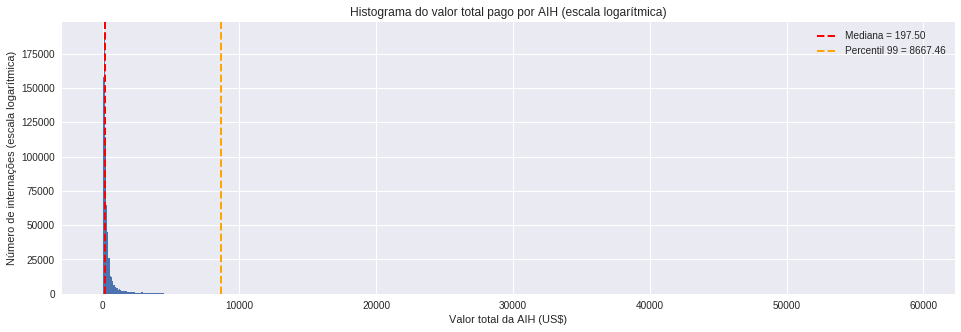

In [11]:
# valor total recebido por AIH
# a escala é logarítmica por causa da amplitude dos valores

hemato.US_TOT.hist(log=False, bins=int(np.sqrt(len(hemato))), figsize=(16, 5))
median = hemato.US_TOT.quantile(.5)

mean = hemato.US_TOT.mean()

p = hemato.US_TOT.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {:.2f}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {:.2f}'.format(p))

plt.xlabel('Valor total da AIH (US$)')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do valor total pago por AIH (escala logarítmica)')
plt.show()

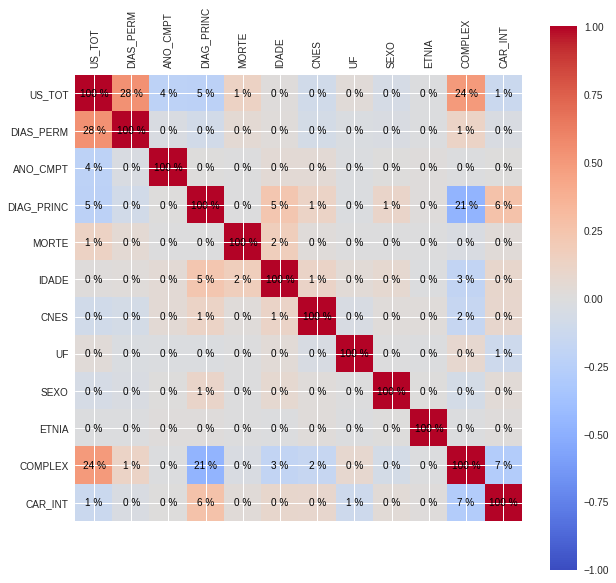

In [12]:
# Searching for correlations using pandas.corr
# TODO: Is this corr the same each year?

data = pd.DataFrame(X_scaled, columns=hemato.columns).drop(['N_AIH', 'DT_INTER', 'DT_SAIDA'], axis=1)
corr = data.corr('spearman')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, '{} %'.format(int(corr.iloc[i, j] ** 2 * 100)),
                       ha="center", va="center", color="k")
plt.show()

# o percentual se refere ao quanto a variação do eixo y é atribuida ao x

In [13]:
from scipy.stats import pearsonr, spearmanr
p = pearsonr(X_scaled[0], X_scaled[1])
s = spearmanr(X_scaled[0], X_scaled[1])

In [14]:
p

(0.44240401056489376, 0.09867948503888282)

In [15]:
s

SpearmanrResult(correlation=0.4535714285714285, pvalue=0.08948590014302728)

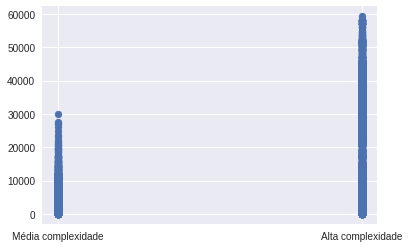

In [16]:
# TODO: ver a corr e a significância

plt.scatter(hemato.COMPLEX.map(comp_map),
            hemato.US_TOT)
plt.show()

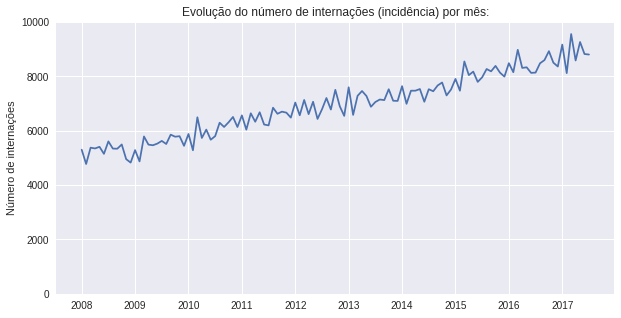

In [17]:
int_by_day = pd.to_datetime(hemato.DT_INTER).value_counts()
# claramente aumentou o número absoluto
# parece que as vezes a velocidade de crescimento diminui um pouco no inverno com picos em fevereiro (?)
# TODO: ver a população a cada ano e ver se aumentou o percentual de internações hemato

int_by_day['2008':'2017'].resample('M').sum()[:-5].plot(figsize=(10, 5),
                                                        ylim=(0, 10000))
plt.title('Evolução do número de internações (incidência) por mês:')
plt.ylabel('Número de internações')
plt.show()

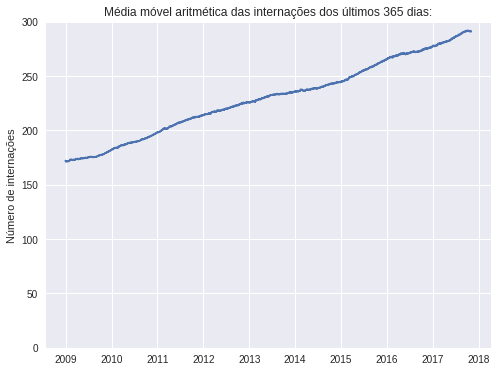

(cada ponto é a média das internações dos últimos 365 dias)


In [18]:
int_by_day['2008':'2017'].resample('D').sum().rolling(365).mean()[:-60].plot(figsize=(8, 6),
                                                                             ylim=(0, 300))
plt.title('Média móvel aritmética das internações dos últimos 365 dias:')
plt.ylabel('Número de internações')
plt.show()
print('(cada ponto é a média das internações dos últimos 365 dias)')

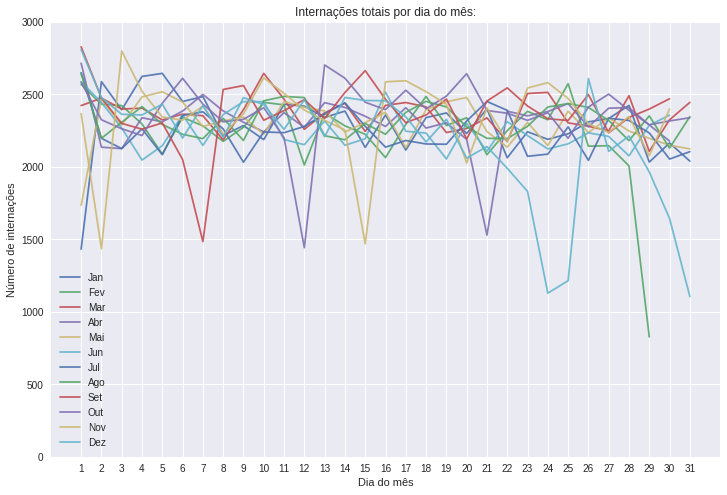

In [19]:
make_daily_int_each_month(hemato)
# os dias com menos internações são feriados

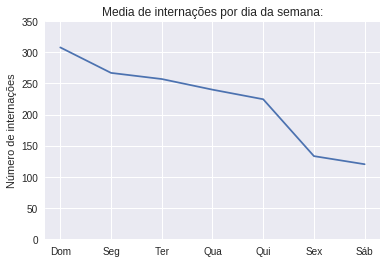

In [20]:
# TODO: fazer bootstrap para ver significância, fazer prevalência

int_by_day.groupby(int_by_day.index.weekday).mean().plot(ylim=(0,350))
plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.title('Media de internações por dia da semana:')
plt.ylabel('Número de internações')
plt.show()

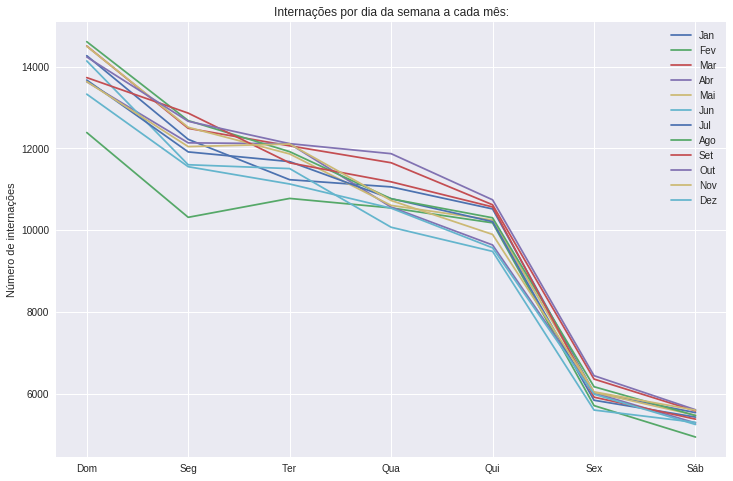

Parece que não muda muito o padrão.


In [21]:
make_weekly_graph(hemato)

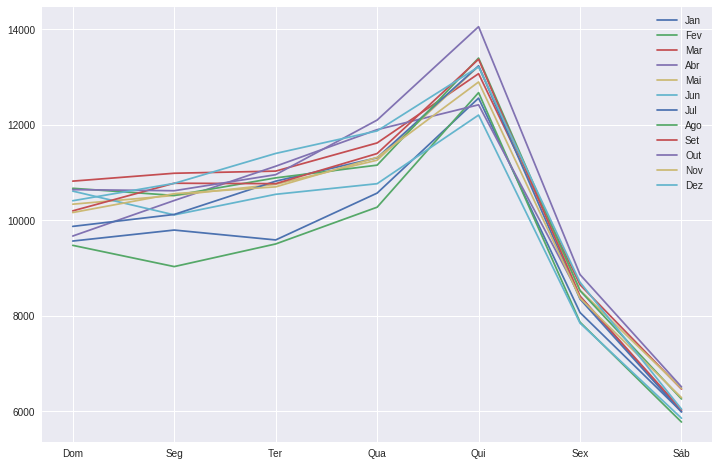

In [22]:
# Altas por dia da semana, em cada mês
# (planejamento de plantões/sobreavisos)
# não é a prevalência, é o número de novas internações (incidência)

pivoted = hemato.pivot_table('N_AIH', index=hemato.DT_SAIDA.dt.weekday, columns=hemato.DT_SAIDA.dt.month,
                             aggfunc='count')

pivoted.columns.name = None
pivoted.columns = months
pivoted.index.name = None

pivoted.plot(figsize=(12, 8), legend=True)
plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.show()

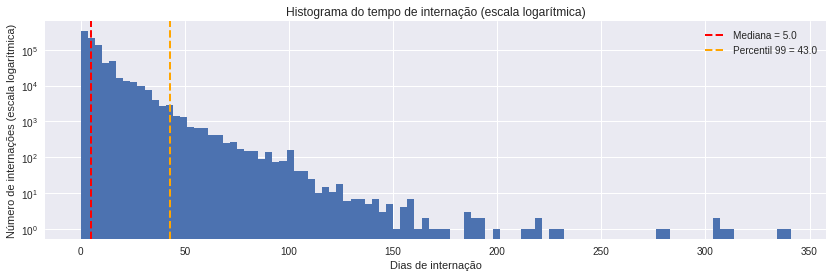

In [23]:
# tempo de internação
# TODO: fazer um ECDF para confirmar a distribuição exponencial

hemato.DIAS_PERM.hist(bins=100, log=True, figsize=(14, 4))
median = hemato.DIAS_PERM.quantile(.5)
p = hemato.DIAS_PERM.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {}'.format(p))

plt.xlabel('Dias de internação')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do tempo de internação (escala logarítmica)')
plt.show()

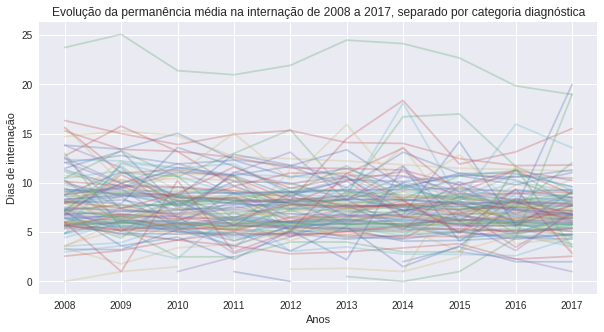

In [24]:
pivoted = hemato.pivot_table('DIAS_PERM', columns='DIAG_PRINC', index='ANO_CMPT', aggfunc='mean')

pivoted.plot(alpha=.3, legend=False, figsize=(10, 5))
plt.xlabel('Anos')
plt.xticks(np.arange(10), pivoted.index)
plt.title('Evolução da permanência média na internação de 2008 a 2017, separado por categoria diagnóstica')
plt.ylabel('Dias de internação')
plt.show()

In [25]:
# continuar procurando realações com o PCA ou alguma tecnica de clusterização

from sklearn.decomposition import PCA
pca = PCA(4)
X_pca = pca.fit_transform(X_scaled)

In [26]:
X_pca.shape

(841112, 4)

In [27]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

In [28]:
labels = ['PC{}'.format(x) for x in range(1, len(per_var) + 1)]

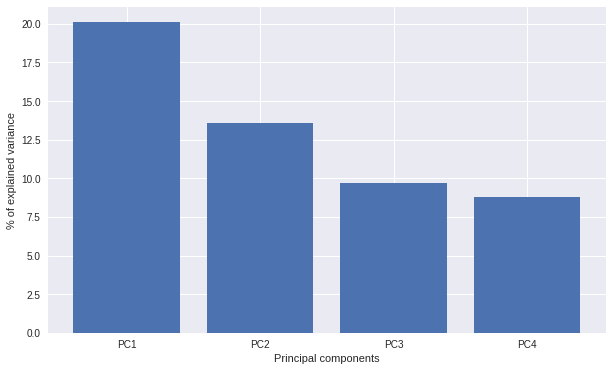

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('% of explained variance')
plt.xlabel('Principal components')
plt.show()
        

In [30]:
X_pca.shape

(841112, 4)

In [31]:
pca_df = pd.DataFrame(X_pca, index=hemato.index, columns=labels)

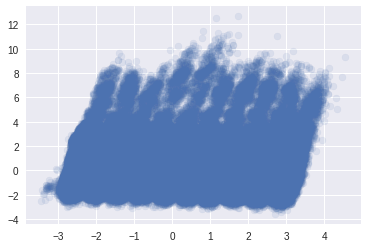

In [32]:
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=.1)#c=pca_df.columns[:2])

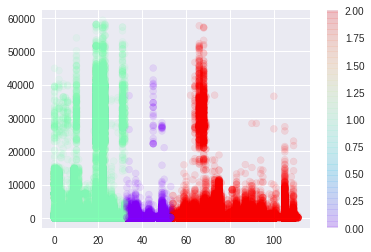

In [33]:
# usando só o US_TOT

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(3)
gmm.fit(X.DIAG_PRINC.values.reshape(-1, 1), y)

labels = gmm.predict(X.DIAG_PRINC.values.reshape(-1, 1))

plt.scatter(X.DIAG_PRINC, y, alpha=.1, c=labels, cmap='rainbow')
plt.colorbar()
plt.show()

In [34]:
# Create a DataFrame with labels and species as columns: df
df = pd.DataFrame({'labels': labels, 'US_TOT': y})

# Create crosstab: ct
ct = pd.crosstab(df['labels'], df['US_TOT'])

# Display ct
print(ct)

US_TOT  0.000000      5.130000      5.220000      5.250000      5.310000      \
labels                                                                         
0                  3             3             1             0             0   
1                  0             8            12            13             6   
2                  1             0             0             1             0   

US_TOT  5.380000      5.400000      5.690000      5.770000      5.840000      \
labels                                                                         
0                  0             0             0             0             0   
1                  9             3            16            12             8   
2                  0             0             0             0             0   

US_TOT  6.010000      6.110000      6.280000      6.290000      6.340000      \
labels                                                                         
0                  2             0    

In [35]:
df.groupby('labels').US_TOT.describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,152080.0,176.122192,582.050720,0.00,95.839996,132.800003,166.072506,44980.289062
1,327355.0,1196.640137,4127.478027,5.13,176.050003,344.019989,700.630005,59332.570312
2,361677.0,379.738464,1734.445801,0.00,126.239998,184.940002,276.410004,57676.761719


## Todo:

X DIAG_PRINC separar CIDs de hemato antes de juntar os arquivos.

X Por que o N_AIH tem numeros repetidos? Interna várias vezes com o mesmo registro? Erro?

Identificar a cidade pelo CEP e verificar quem tem um endereço e interna em outra cidade/estado.

Posso usar o MUNIC_RES pra fazer o que escrevi acima.

UTI_MES_TO e UTI_INT_TO pode dizer quais CIDs são mais graves. Se o percentual de internações graves aumentou. Posso relacionar se morrem muito na UTI ou se salvam muito.

Hemato ganha muita diaria de acompanhante? DIAR_ACOM

Quais CIDs ficam mais tempo internado? QT_DIARIAS Algum estado demora mais no tratamento, comparando mesmas doenças? Isso se reflete no resultado do tto?

----------
##### Financeiro

VAL_SH (hosp) VAL_SP (profissional) VAL_TOT VAL_UTI US_TOT Quanto paga cada internação de hemato? Qual paga mais?

FINANC A grana vem de onde?

VAL_SADT, VAL_ACOMP, VAL_SANGUE está zerado???

90 VAL_SH_FED numeric (10, 2) Valor do complemento federal de serviços hospitalares. Está
 incluído no valor total da AIH.

91 VAL_SP_FED numeric (10, 2) Valor do complemento federal de serviços profissionais. Está
 incluído no valor total da AIH.

92 VAL_SH_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços hospitalares. Está incluído no valor total da AIH.

93 VAL_SP_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços profissionais. Está incluído no valor total da AIH.
 
VAL_UCI O que é UCI???

-----------

DT_INTER DT_SAIDA DIAS_PERM Datas de int e alta conferem com as diárias? Há datas de anos/meses anteriores que contaram nesta competencia (atraso de envio?)

Não incluí a natureza jurídica e a gestão porque é certo que vai ter mais internações nos tipos de lugares que existem, seja por imposição legal ou incentivo fiscal. Não quer dizer que sejam mais importantes.

MUNIC_MOV Municipio do estabelecimento. Este dado é confiável? Se for, posso usar pra comparar com o MUNIC_RES.

COD_IDADE IDADE Perfil de idade dos pacientes atendidos.

NACIONAL Nacionalidade do paciente

CAR_INT Vem muito pct hemato de emergência?

CBOR NUM_FILHOS INSTRU VINCPREV Acho importante pra comparar por regiões e por tempo, mas tenho dúvidas da veracidade dos dados.

RACA_COR ETNIA Comparar as duas classificações.

Qual a prevalência de pacientes internados? (Como calcular a prevalencia?)